In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import re
import sklearn

import matplotlib.colors
import matplotlib.pyplot as plt

from collections import Counter
from gensim.models import KeyedVectors, Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from tqdm import tqdm

from sklearn import model_selection, naive_bayes, metrics, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from iteration_utilities import deepflatten

os.chdir('D:\Scraping')

In [2]:
import imblearn
from imblearn.over_sampling import SMOTE
print("SMOTE", imblearn.__version__)
sm = SMOTE(random_state=0, ratio=1.0)

ModuleNotFoundError: No module named 'imblearn'

<br></br>
# [1. Assegnazione delle classi](#1)
<br></br>
## [1.1 Dataset](#1.1)

<font size=3>
    
I dataset caricati per questo notebook sono:
* `imdb_df4`: era l'ultimo creato nel notebook del pre-processing, al suo interno sono contenute le informazioni sul titolo del film, lo score e le recensioni già divide in frasi.
* `diz_simiarity`: dizionario con i sinonimi ricavati tramite la matrice di similarità con l'approccio su `Wordnet`. Ad ogni parola, elemento chiave, corrisponde una lista si sinonimi, parole che avevano massima similarità con la chiave.
* `w_pattern`: anch'esso ottenuto nel precedente notebook è una lista in cui al suo interno sono presenti i pattern (di parole) significativi identificati nelle frasi delle recensioni.
* `labels_df simlified`: è il file `.csv` con le parole, la loro frequenza e il cluster di appartenenza. È stato modificato per fare in modo che le classi meno numerose siano raggruppate insieme ad altre.
* `imdb_info`: ottenuto nel processo di scraping, contiene le informazioni sui film, la più importante è il nome degli attori.

In [2]:
%%time
# dataframe
with open('imdb_df4', "rb") as input_file:
    imdb_df = pickle.load(input_file)
    
with open("diz_similarity", "rb") as input_file:
    diz_similarity = pickle.load(input_file)
    
with open('w_pattern', "rb") as input_file:
    words = pickle.load(input_file)

labels = pd.read_csv('labels_df.csv', delimiter=",")
info = pd.read_csv("imdb_info.csv", delimiter="\t")

Wall time: 13 s


In [87]:
labels = pd.read_csv('labels_df simplified.csv', delimiter=";")

<font size=3>
    
Dal dataset delle etichette si aggiunge la lista di sinonimi alla rispettive parole tramite la funzione `map`.

In [3]:
labels["Synonyms"] = labels["Word"].map(diz_similarity)

labels.head()

,Word,Label,Freq,Synonyms
0,film,10,427813,"[movie, pic]"
1,story,8,189781,"[narrative, tale, narration]"
2,time,10,101632,[]
3,character,4,86915,[]
4,plot,4,71089,[]


<font size=3>

Da questo dataset sono creati due dizionari, `diz_cluster` e `diz_freq`: il primo avrà come chiave una delle parole più frequenti e come valore la classe di appartenenza, nel secondo la chiave c'è la stessa chiave e il valore è la frequenza. Questo stesso procedimento è realizzato inseriendo anche i sinonimi dove in questo caso la frequenza è assegnata in base alla parola di riferimento.

In [4]:
diz_cluster = {}
diz_freq = {}
for i in range(len(labels)):
    
    if labels["Word"].iloc[i] not in diz_cluster.keys():
        diz_cluster[labels["Word"].iloc[i]] = labels["Label"].iloc[i]
        diz_freq[labels["Word"].iloc[i]] = labels["Freq"].iloc[i]
        
    if len(labels["Synonyms"].iloc[i]) > 0:
        for word in labels["Synonyms"].iloc[i]:
            if word not in diz_cluster.keys():
                diz_cluster[word] = labels["Label"].iloc[i]
                diz_freq[word] = labels["Freq"].iloc[i]

<font size=3>
    
Per il dataset sulle informazioni degli attori è necessario effettuare un pre-processing in quanto salvando delle liste in un dataframe e il tutto come `.csv`, una volta caricati, gli elementi sono sempre considerati come stringhe e non come gli oggetti che erano realmente. Attraverso una regular expression della libreria `re` si ricrea una lista di attori per ogni film utilizzando la virgola come carattere separatore degli elementi e rimuovendo la punteggiatura. I risultati sono inseriti nel dizionario `diz_actor` in cui la chiave è il titolo del film e il valore una lista degli attori protagonisti.

In [5]:
diz_actor = {}
for i in range(len(info)):
    temp = list(info["Actor"].iloc[i].split(","))
    actors = [re.sub(r'[^\w\s]', '', temp[i].strip(" ")) for i in range(len(temp))]
    title = (info["Title"].iloc[i])
    diz_actor[title] = actors

<font size=3>
    
La colonna con i titoli dei film nel dataset delle recensioni viene trasformata in una lista. Sempre attraverso la funzione `map` si assegna ad ogni titolo la lista degli attori protagonisti (la funzione richiede che l'oggetto messo come argomento sia un dizionario).

In [6]:
df_title_list = list(imdb_df["Title"])
new_df = pd.DataFrame({"Title":df_title_list})
new_df["Actors"] = new_df["Title"].map(diz_actor)
new_df

,Title,Actors
0,Le Mans '66 - La grande sfida (2019),"[Matt Damon, Christian Bale, Jon Bernthal, Cai..."
1,Le Mans '66 - La grande sfida (2019),"[Matt Damon, Christian Bale, Jon Bernthal, Cai..."
2,Le Mans '66 - La grande sfida (2019),"[Matt Damon, Christian Bale, Jon Bernthal, Cai..."
3,Le Mans '66 - La grande sfida (2019),"[Matt Damon, Christian Bale, Jon Bernthal, Cai..."
4,Le Mans '66 - La grande sfida (2019),"[Matt Damon, Christian Bale, Jon Bernthal, Cai..."
...,...,...
784254,Il ritorno di Casanova (1992),NaN
784255,Amici per la vita (1992),[]
784256,Amici per la vita (1992),[]
784257,Amici per la vita (1992),[]


<br></br>
## [1.2 Assegnazione](#1.2)

<font size=3>
    
In questo passaggio verraano assegnate le etichette ad ogni pattern rilevante, tenendo presente non solo le informazioni ottenute tramite la cluster analysis, ma anche informazioni esterne ottenute in altri passaggi come il nome degli attori. La prima riga di codice è creare una lista con gli attori presenti in ogni film, ricavato nel passaggio precedente. Questa lista contiene dei duplicati in quanto il riferimento è la singola recensione e non un titolo univoco di film, ma mantenendo questo ordine è possibile far corrispondere questa lista a quella dei pattern rilevanti in quanto la lunghezza dei due oggetti è la stessa, $784259$ elementi, la lunghezza del dataframe originale creato mediante scraping.

In [7]:
actors_list = list(new_df["Actors"])

<font size=3>
    
La seguente funzione di effettuare l'assegnazione. I passaggi sono:
* Creazione di una lista in cui saranno salvate le classi assegnate, `category_list`. Si itera all'interno della lista dei pattern:
    * In ogni elemento è presente una lista con i pattern rilevanti di ogni frase. Sono create delle liste temporanee dove saranno salvate le etichette e delle variabili di controllo, `check` e `max_freq`.
        * Si itera all'interno di ogni lista di pattern rilevanti di frasi in quanto è possibile che una singola frase abbia più pattern rilevanti al suo interno, dunque più elementi e quindi la lista era il formato più comodo per salvare questa informazione. 
        * Se la lunghezza del topic non è nulla, quindi esiste almeno un pattern rilevante per quella frase, si controlla se nella lista degli attori di quel film (ricavabile tramite l'indice della recensione), almeno uno compare nel testo. In caso positivo lo si segnala con una variabile, `actor_value`, altrimenti si procede,
        * Per ogni parola nel pattern rilevanti si controlla quale sia l'eventuale cluster di appartenenza, in caso di assenza fra i termini più comuni si assegna il valore $-1$. Si controlla anche la frequenza delle parole di cui viene presa la minima e la classe di riferimento.
        * Ci crea una lista escludendo i valori negativi delle parole non trovate e si effettua un conteggio delle etichette più frequenti:
            * Se la classe più numerosa è unica e non ci sono attori nel pattern, tutto quel pattern avrà come etichetta quello della classe più comune.
            * Se ci sono più classi con la stessa frequenza si premia quella della parola con la frequenza minore (più rara), in modo da non sfavorire i termini meno comuni.
            * Se è presente almeno un attore nel pattern, il pattern è contrassegnato con una nuova etichetta che rappresenta la classe degli attori.

I risultati sono salvati in una lista per ogni frase e in un'altra lista per ogni recensione. Il risultato finale sarà una lista con tanti elementi quante erano le recensioni originarie e all'interno di ogni elemento una lista con la classe relativa al pattern identificato.

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
category_list = []
temp = []
for k in tqdm(range(len(words))): # si itera per ogni recensione
    sentence_list = []
    
    for sentence in words[k]: # si itera per ogni frase nella recensione
        temp_list = []
        temp_list2 = []
        check = -1
        max_freq = 1000000
        
        for topic in sentence: # si itera per ogni pattern rilevante nella recensione
            actor_value = 0
            fict_value = 0
            dir_value = 0
            writer_value = 0
            
            # si controlla se la lunghezza è nulla o ci siano nomi di attori
            if len(topic) == 0:
                temp_list2.append('')
                break
            if (type(actors_list[k]) == list) and (len(actors_list[k]) > 0):
                for actor in actors_list[k]:
                    if actor in topic and len(actor) > 2:
                        actor_value = 1

            # si itera per ogni parola nel pattern rilevante per identificarne l'appartenenza ad un cluster            
            w = topic.split(" ")
            for z in range(len(w)):
                category = 100
                if w[z].lower() in diz_cluster.keys() and w[z] not in stop:
                    category = diz_cluster[w[z].lower()]
                    freq = diz_freq[w[z].lower()]
                    if freq < max_freq:
                        max_freq = freq
                        check = category
                    if z > 0:
                        if (type(actors_list[k]) == list) and (len(actors_list[k]) > 0):
                            for actor in actors_list[k]:
                                if len(actor) > 2 and w[z] in actor:
                                    actor_value = 1
                
                temp_list.append(category)
                
            # si assegna al pattern la classe più frequente nelle sue parole
            temp_list = [el for el in temp_list if el != 100]
            mc = Counter(temp_list).most_common()
            if len(mc) > 1 and (actor_value == 0):
                if mc[0][1] != mc[1][1]:
                    temp_list2.append(mc[0][0])
                else:
                    for i in range(len(mc)):
                        if check != 100:
                            if mc[i][0] == check:
                                temp_list2.append(mc[i][0])
                                break
                        else:
                            temp_list2.append(mc[0][0])
                            break

            elif len(mc) == 1:
                temp_list2.append(mc[0][0])
                
            elif len(mc) == 0 and (actor_value == 0):
                temp_list2.append(-1)

            elif actor_value == 1:
                temp_list2.append(100)
 
        sentence_list.append(temp_list2)
    category_list.append(sentence_list)

100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [02:25<00:00, 5392.46it/s]


<font size=3>
    
I pattern con etichetta $-1$ sono stati considerati, rappresentano un nuovo cluster in cui non sono presenti dei termini molto frequenti e saranno la classe degli elementi generali. Sono però rimossi gli elementi nulli, ovvero quelli relativi a quelle frasi dove non è stato riscontrato nessun pattern rilevante, questo viene realizzato sia per le etichette che per le parole.

In [11]:
%%time
test = [el for el in list(deepflatten(category_list, depth=2)) if el != '']
test2 = [el for el in list(deepflatten(words, depth=2)) if el != '']
print(len(test), len(test2))

14149712 14149712
Wall time: 34.9 s


<font size=3>
    
Da queste liste si crea un dataset dove la colonna `Topic` rappresenta il pattern di interesse e la colonna `Label` la classe di riferimento.

In [12]:
t = pd.DataFrame({"Topic":test2, "Label":test})
t.head()

,Topic,Label
0,Amazing chemistry,4
1,seamless CGI,4
2,practical effects,4
3,film a firecracker script a true,4
4,story pulse pounding soundtrack booming,8


In [13]:
Counter(t["Label"]).most_common()

[(10, 3054097),
 (-1, 2639727),
 (6, 1809667),
 (0, 1554947),
 (4, 1443049),
 (8, 1185345),
 (1, 634368),
 (9, 490627),
 (11, 448842),
 (3, 381970),
 (100, 266505),
 (7, 125702),
 (2, 76339),
 (5, 38527)]

In [23]:
with open("pattern_labels", "wb") as output_file:
    pickle.dump(t, output_file)

<br></br>
<br></br>
# [2. Modelli di classificazione](#2)

<font size=3>
    
Tramite la funzione `train_test_split` di `sklearn` si ricavano il train e il test del dataset. Nelle variabili il cui nome inizia per "<b>X</b>" sono presenti i pattern di train e di test, nella variabili che iniziano per "<b>y</b>" le etichette di train e di test. Per replicare i risultati e confrontare diveri modelli viene impostato un random seed e la tecnica per scegliere quali osservazioni rientrano nel test o nel train segue l'approccio di stratificazione, ovvero le proporzioni di etichette presenti nel dataset completo si rispecchieranno anche all'interno del train e del test. Non specificando la dimensione del train e del test si applicano i valori di default $70\%$ e $30\%$.

Per applicare una corretta classificazione è necessario trasformare il testo in un oggetto che sia comprensibile ai modelli. La soluzione per cui si è optato è quella del <b>TF-IDF</b> (<i>Term frequency - Inverse document frequency</i>), una metrica che esprime l'importanza di termine in un documento relativamente ad un corpus di documenti. La funzione è composta da due parti: una è la frequenza del termine e l'altra è la frequenza inversa all'interno dei documenti. Lo scopo di questa metrica è premiare le parole frequenti globalmente nel corpus ma presenti in pochi documenti. Esistono diversi metodi per calcolare questa metrica, in `sklearn` la formula utilizzata per il <b>TF-IDF</b> dato un termine $t$ e un documento $d$ è:
$$ TFIDF_{(t,d)} = tf{(t,d)} \times idf{(t)} $$

Dove $tf{(t,d)}$ è il numero di volte che compare il termine $t$ nel documento $d$ e l'altra quantità è pari a: $idf{(t)} = log{\frac{n}{df(t)}}$ con $n$ il numero totale di documenti.

Il primo step è inizializzare questa funzione mediante `TfidfVectorizer` i parametri che riceve in ingresso sono:
* `analyzer`: la tipologia utilizzata per analizzare il testo, in questo caso si seleziona a livello di parola ma è possibile analizzare anche n-grammi.
* `token_pattern`: espressione regolare per definire cosa sia un token. In questo caso a tutte le parole sono rimossi gli elementi di punteggiatura o alfanumerici `\w` di lunghezza pari a uno o superiore `{1,}`.
* `max_features`: il numero di termini da considerare, nel caso ci siano più termini di quelli massimi, si selezionano i più frequenti. Effettuare una analisi con termini rari, anche se si lavoro con una metrica particolare, i risultati possono risentirne in alcuni casi, fissando un limite ragionevole si possono ottenere delle discrete performance.

Il secondo passaggio è quello di centrare/normalizzare i dati togliendo una media comune $\mu$ e dividendo per una variazione $\sigma$. Questi passaggi sono possibili mediante la funzione `fit_transform` che può essere applicata direttamente alla funzione TF-IDF mettendo come input il vettore dei pattern di train. Per i dati di test i valori con cui sono centrati i dati devono essere gli stessi, non si deve riapplicare l'intera funzione ma è sufficiente il metodo `transform`. La funzione `fit_transform` unisce sia la funzione `fit` per salvare i due parametri e `transform` per applicare la trasformazione, richiamando solo il secondo la trasformazione viene realizzata correttamente in quanto i valori sono già stati creati e salvati da `fit_transform` sul train.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(t["Topic"], t["Label"], stratify = t["Label"], random_state = 0)
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=200000, ngram_range=(1,2))
xtrain_tfidf =  tfidf_vect.fit_transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

<font size=3>
    
Per la matrice di errata classificatione viene definita una nuova scala di colori, totalmente incentrata sul rosso. Come primo passaggio si definisce il range di valori, $[-1,1]$, successivamente una lista di tonalità in corrispondenza di un valore all'interno del range. Con la funzione `LinearSegmentedColormap.from_list` è possibile ridefinire un colore in base ad una lista di valori creati dall'utente. In questo caso si crea un nuovo oggetto che non sostituisce nessuno già esistente ma che presenta la nuova scala di valori.

In [15]:
norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "lightyellow"],
          [norm(-0.95), "antiquewhite"],
          [norm(-0.8), "wheat"],
          [norm(-0.3), "navajowhite"],
          [norm( 0.3), "orange"],
          [norm( 0.8), "tomato"],
          [norm( 0.9), "red"],
          [norm( 1.0), "darkred"]]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

<font size=3>

La funzione `train_model` permette di applicare un metodo di classificazione e di visualizzarne i risultati. I parametri in input sono:
* `classifier`: un metodo di classificatione.
* `feature_vector_train`: un vettore con i dati di train.
* `label`: un vettore con le etichette relative alle osservazioni del train.
* `feature_vector_valid`: un vettore con i dati di test.
* `method`: stringa con il nome del metodo, serve solamente per il print dei risultati.

In questa funzione il classificatore prende in input il vettore dei dati e delle etichette di test e lo si allena con la funzione `fit`. A questo classificatore addestrato viene applicata la funzione `predict` che restituisce come output un vettore di etichette relative al vettore di test dato in input.

Si stampa il report di classificazione comparando il vettore delle etichette di test e il vettore delle etichette prodotto dal modello. Da esso si ricava anche la matrice di confusione.

Per la visualizzazione della matrice si utilizza `matplotlib` per creare l'oggetto e la matrice viene scalata in base ai valori di riga, in modo tale da visualizzare le percentuali e non il numero totale di osservazioni, così facendo la scala di colori definita in precedenza sarà coerente con la proporzione di osservazioni all'interno di ogni cella e non sul numero totale (che non è indicativo delle performance in quanto le classi non sono bilanciate e celle più numerose non corrispondono necessariamente a classificazioni migliori). Si ricava infine il valore di accuratezza che è messo come output della funzione.

In [16]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, method):
    
    # train classification
    classifier.fit(feature_vector_train, label)
    
    # prediction on test
    predictions = classifier.predict(feature_vector_valid)
    
    # report
    print(classification_report(y_test, predictions))
    
    # confusion matrix
    cm = confusion_matrix(predictions, y_test)
    print(cm)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=cmap)
    fig.colorbar(cax)

    plt.title('Confusion matrix of ' + method, pad=40)
    #ax.set_xticklabels([''] + shortfilename, rotation=45)
    #ax.set_yticklabels([''] + shortfilename)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return metrics.accuracy_score(predictions, y_test)

<br></br>
## [2.1 Naive Bayes](#2.1)

<font size=3>
    
Utilizza il teorema di Bayes per stimare le probabilità di appartenenza di un'osservazione ad una determinata classe; è uno dei metodi più utilizzati nella classificazione di testi ed è spesso utilizzato con dei dati rappresentati da un vettore TF-IDF. Per ogni classe $y$ il modello crea un vettore $\theta_y = (\theta_{y1}, \theta_{y2}, \dots, \theta_{yn})$ in cui ogni singolo elemento rappresenta la probabilità $P(x_i|y)$ di appartenenza di quel termine alla classe $y$; il vettore ha lunghezza $n$ come il numero di termini dati in input.

I valori di probabilità sono stimati mediante una funzione di massima verosimiglianza incentrata sulle frequenze:

$$ \hat{\theta}_{yi} = \frac{N_{yi} + \alpha}{N_y + \alpha n}$$

Dove $N_{yi} = \sum_{x \in T}{x_i}$ è il numero di volte che un termine compare in un campione della classe $y$ nel training set $T$ e $N_y = \sum_{i=1}^{n}{N_{yi}}$ è il numero totale di termini nella classe $y$.

Il valore $\alpha$ è chiamato fattore di smoothing e di default è pari a $1$; serve per gestire i casi in cui nel test set si trovino dei termini non presenti nel train evitando problemi di calcolo o l'assegnazione diretta di probabilità nulle.

              precision    recall  f1-score   support

          -1       0.59      0.83      0.69    659932
           0       0.71      0.64      0.68    388737
           1       0.70      0.63      0.66    158592
           2       0.69      0.57      0.62     19085
           3       0.72      0.62      0.67     95492
           4       0.74      0.64      0.69    360762
           5       0.69      0.55      0.61      9632
           6       0.70      0.66      0.68    452417
           7       0.71      0.57      0.63     31426
           8       0.72      0.65      0.68    296336
           9       0.68      0.60      0.63    122657
          10       0.78      0.69      0.73    763524
          11       0.69      0.61      0.65    112210
         100       0.38      0.49      0.43     66626

    accuracy                           0.68   3537428
   macro avg       0.68      0.62      0.65   3537428
weighted avg       0.70      0.68      0.68   3537428

[[550198  51813  22622   

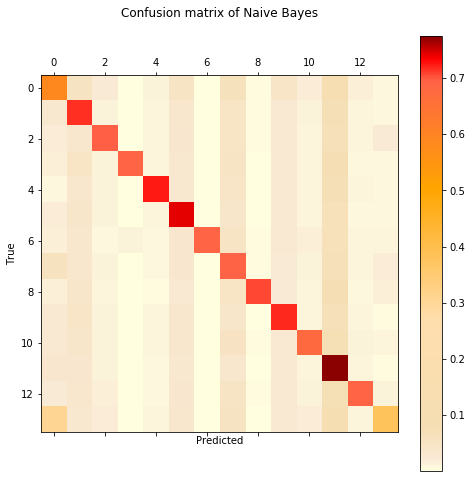

NB, WordLevel TF-IDF:  0.6825133967390997
Wall time: 14.7 s


In [17]:
%%time
accuracy = train_model(naive_bayes.ComplementNB(), xtrain_tfidf, y_train, xtest_tfidf, "Naive Bayes")
print ("NB, WordLevel TF-IDF: ", accuracy)

<font size=3>
    
La regressione logistica si basa sul modello logistico per ricavare la classificazione delle osservazioni in due o più classi. Gli step del classificatore sono:
* I dati in input sono inseriti all'interno di un modello a cui sono associati dei pesi aggiornati iterazione per iterazione.
* Gli output di questo modello sono passati ad una funzione di attivazione che scala i valori in modo tale che la loro somma sia unitaria.
* Si applica una funzione di cross-entropia per valutare la distanza fra la classificazione effettuata dal modello e le reali classi dei dati.
* In base ai valori ottenuti si aggiornano i pesi cercando di minimizzare una funzione di perdita. L'aggiornamento dei pesi procede fino a quando la perdita è nulla o la variazione fra un'iterazione e l'altra è eccessivamente ridotta.

Gli input della funzione sono:
* `penalty`: `sklearn` applica automaticamente una penalizzazione della funzione di perdita. Questa penalizzazione viene effettuata normalmente tramite una <i>ridge regression</i> per preferire modelli più semplici con lo scopo di ridurre l'overfitting. 
* `C`: Tutte le funzioni di penalizzazione prevedono un parametro $\lambda$ dove più è alto, più i modelli complessi saranno penalizzati. Questo parametro rappresenta $\frac{1}{\lambda}$ che funziona al contrario, dunque più è alto, più l'influenza di $\lambda$ sarà ridotta e i modelli complessi poco penalizzati.
* `solver`: è il metodo utilizzato per minimizzare la funzione di perdita.

              precision    recall  f1-score   support

          -1       0.59      0.98      0.74    659932
           0       0.77      0.65      0.71    388737
           1       0.76      0.64      0.69    158592
           2       0.75      0.53      0.62     19085
           3       0.77      0.62      0.68     95492
           4       0.79      0.66      0.72    360762
           5       0.76      0.50      0.61      9632
           6       0.78      0.66      0.72    452417
           7       0.77      0.56      0.65     31426
           8       0.78      0.65      0.71    296336
           9       0.74      0.59      0.66    122657
          10       0.80      0.72      0.75    763524
          11       0.75      0.62      0.68    112210
         100       0.52      0.41      0.46     66626

    accuracy                           0.72   3537428
   macro avg       0.74      0.63      0.67   3537428
weighted avg       0.74      0.72      0.72   3537428

[[647450  59556  24788   

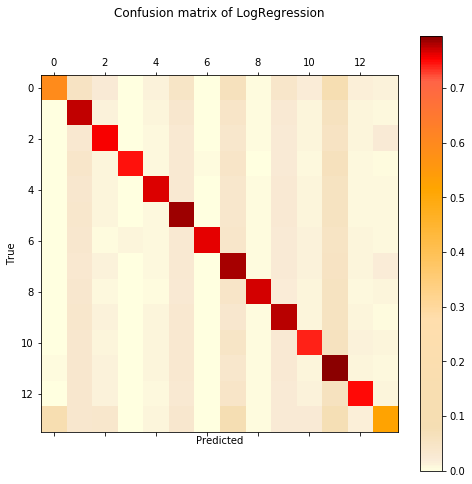

LogisticRegression, WordLevel TF-IDF:  0.7183374474335591
Wall time: 7min 24s


In [18]:
%%time
from sklearn.linear_model import LogisticRegression
accuracy = train_model(LogisticRegression(random_state=0, n_jobs=5, solver="sag"), 
                       xtrain_tfidf, y_train, xtest_tfidf, "LogRegression")
print ("LogisticRegression, WordLevel TF-IDF: ", accuracy)

<font size=3>
    
Il modulo `MLPClassifier` permette di creare delle reti neurali per la classificazione. Dato in input un layer dei dati, si applicano dei pesi lineari all'interno dei layer nascosti, fra un layer nascosto e il successivo si applica una funzione di attivazione non lineare. L'algoritmo procede fino a quando la funzione di perdita non si aggiorna di una quantità sufficiente. I parametri della funzione sono:
* `solver`: algoritmo per l'ottimizzazione dei pesi.
* `alpha`: come per il modello logistico, anche la rete neurale presenta una penalizzazione.
* `hidden_layer_sizes`: si definiscono quanti neuroni e quanti layer nascosti devono esserci.

              precision    recall  f1-score   support

          -1       0.57      0.93      0.71    708277
           0       0.60      0.54      0.57    340196
           4       0.63      0.53      0.57    329013
           6       0.60      0.55      0.57    366862
           8       0.64      0.50      0.56    293703
           9       0.50      0.48      0.49    100021
          10       0.71      0.62      0.66    873930
          11       0.55      0.49      0.52    100286
          50       0.61      0.52      0.56    289585
         100       0.52      0.20      0.29    135555

    accuracy                           0.61   3537428
   macro avg       0.59      0.53      0.55   3537428
weighted avg       0.62      0.61      0.60   3537428

[[655601  56015  52217  62654  50148  19177 135189  16980  47609  47301]
 [  6451 183536  16285  18398  15905   4404  38809   4424  13022   7179]
 [  4199  14004 174151  13748  12864   3571  33172   3705  10890   6638]
 [ 10882  16300  15362

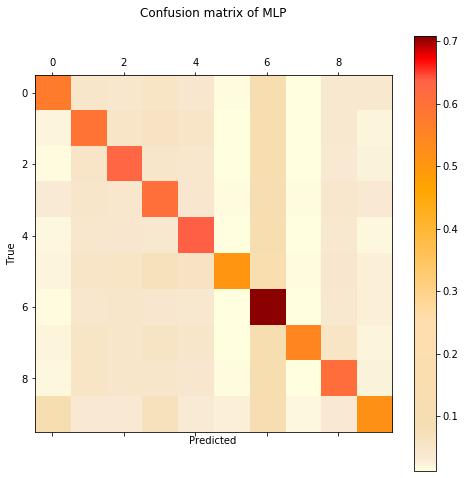

MLP, WordLevel TF-IDF:  0.6147028292872675
Wall time: 28min 36s


In [27]:
%%time
accuracy = train_model(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,), random_state=0), 
                       xtrain_tfidf, y_train, xtest_tfidf, "MLP")
print ("MLP, WordLevel TF-IDF: ", accuracy)

In [8]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [9]:
model = Word2Vec.load("IMDB_word2vec.model")

In [89]:
w2v_diz_sim = {}
for i in tqdm(range(len(labels))):
    temp = []
    try:
        sim = model.most_similar(labels["Word"].iloc[i])
        for j in range(len(sim)):
            if sim[j][0].lower() != labels["Word"].iloc[i] and sim[j][0] not in labels["Synonyms"].iloc[i] and "_" not in sim[j][0]:
                temp.append(sim[j][0].lower())
    except KeyError:
        pass
    w2v_diz_sim[labels["Word"].iloc[i]] = temp

  0%|                                                                                          | 0/849 [00:00<?, ?it/s]C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
100%|███████████████████████████████████████████████████████████████████████████████| 849/849 [00:01<00:00, 812.46it/s]


In [90]:
for i in range(len(labels)):
    labels["Synonyms"].iloc[i] = labels["Synonyms"].iloc[i] + list(w2v_diz_sim.values())[i]
labels.head()

C:\Users\Hp\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Word,Label,Freq,Synonyms
0,way,0,68935,"[manner, style, fashion, mode, ways, situation..."
1,life,0,61168,"[existence, lifestyle, childhood, lives, dream..."
2,thing,0,60468,"[what, things, something, something, complaint..."
3,love,0,29193,"[adore, romance, loved, loves, hate, loving]"
4,problem,0,16458,"[issue, flaw, complaint, problems, gripe]"


In [91]:
diz_cluster = {}
diz_freq = {}
for i in range(len(labels)):
    
    if labels["Word"].iloc[i] not in diz_cluster.keys():
        diz_cluster[labels["Word"].iloc[i]] = labels["Label"].iloc[i]
        diz_freq[labels["Word"].iloc[i]] = labels["Freq"].iloc[i]
        
    if len(labels["Synonyms"].iloc[i]) > 0:
        for word in labels["Synonyms"].iloc[i]:
            if word not in diz_cluster.keys():
                diz_cluster[word] = labels["Label"].iloc[i]
                diz_freq[word] = labels["Freq"].iloc[i]
                
                
diz_actor = {}
for i in range(len(info)):
    temp = list(info["Actor"].iloc[i].split(","))
    actors = [re.sub(r'[^\w\s]', '', temp[i].strip(" ")) for i in range(len(temp))]
    title = (info["Title"].iloc[i])
    diz_actor[title] = actors

In [92]:
df_title_list = list(imdb_df["Title"])
new_df = pd.DataFrame({"Title":df_title_list})
new_df["Actors"] = new_df["Title"].map(diz_actor)

actors_list = list(new_df["Actors"])

In [103]:
category_list = []
for k in tqdm(range(len(words))): # si itera per ogni recensione
    sentence_list = []
    
    for sentence in words[k]: # si itera per ogni frase nella recensione
        temp_list = []
        temp_list2 = []
        check = -1
        max_freq = 1000000
        
        for topic in sentence: # si itera per ogni pattern rilevante nella recensione
            actor_value = 0
            
            # si controlla se la lunghezza è nulla o ci siano nomi di attori
            if len(topic) == 0:
                temp_list2.append('')
                break
            if type(actors_list[k]) == list:
                for actor in actors_list[k]:
                    if actor in topic:
                        actor_value = 1
                        
            # si itera per ogni parola nel pattern rilevante per identificarne l'appartenenza ad un cluster            
            w = topic.split(" ")
            for word in w:
                category = -1
                if word in diz_cluster.keys():
                    category = diz_cluster[word]
                    freq = diz_freq[word]
                    if freq < max_freq:
                        max_freq = freq
                        check = category
                
                temp_list.append(category)
                
            # si assegna al pattern la classe più frequente nelle sue parole
            temp_list = [el for el in temp_list if el != -1]
            mc = Counter(temp_list).most_common()
            if len(mc) > 0 and actor_value == 0:
                if mc[0][0] != mc[0][1]:
                    temp_list2.append(mc[0][0])
                else:
                    for i in range(len(mc)):
                        if mc[i][0] == check:
                            temp_list2.append(mc[i][0])
                            break
            if actor_value == 1:
                temp_list2.append(100)
            if len(mc) == 0 and actor_value == 0:
                temp_list2.append(-1)
        
        sentence_list.append(temp_list2)
    category_list.append(sentence_list)

100%|████████████████████████████████████████████████████████████████████████| 784259/784259 [02:08<00:00, 6101.38it/s]


In [110]:
%%time
test = [el for el in list(deepflatten(category_list, depth=2)) if el != '']
test2 = [el.lower() for el in list(deepflatten(words, depth=2)) if el != '']
print(len(test), len(test2))

14149712 14149712
Wall time: 2min 30s


In [113]:
t2 = pd.DataFrame({"Topic":test2, "Label":test})
t2.head()

,Topic,Label
0,amazing chemistry,4
1,seamless cgi,4
2,practical effects,4
3,film a firecracker script a true,4
4,story pulse pounding soundtrack booming,4


In [106]:
Counter(t2["Label"]).most_common()

[(0, 3585182),
 (50, 2964963),
 (6, 2874585),
 (4, 1522237),
 (-1, 963415),
 (10, 824122),
 (100, 542221),
 (8, 362454),
 (9, 277200),
 (11, 233333)]

In [114]:
X_train, X_test, y_train, y_test = train_test_split(t2["Topic"], t2["Label"], stratify = t2["Label"], random_state = 0)
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=20000)
xtrain_tfidf =  tfidf_vect.fit_transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

              precision    recall  f1-score   support

          -1       0.57      0.33      0.42    240854
           0       0.49      0.75      0.59    896295
           4       0.62      0.37      0.46    380559
           6       0.55      0.60      0.57    718646
           8       0.56      0.13      0.21     90614
           9       0.56      0.09      0.16     69300
          10       0.61      0.17      0.26    206031
          11       0.68      0.16      0.26     58333
          50       0.52      0.58      0.55    741241
         100       0.49      0.37      0.42    135555

    accuracy                           0.53   3537428
   macro avg       0.56      0.35      0.39   3537428
weighted avg       0.54      0.53      0.50   3537428

[[ 78764  13247   6334  11796   1872   1325   3602   2171  11143   8267]
 [ 69145 668259 108334 150047  32987  31401  72305  18861 174335  29057]
 [  3991  21456 140555  21023   3995   2068   7235   1931  20613   3923]
 [ 37878  78397  58032

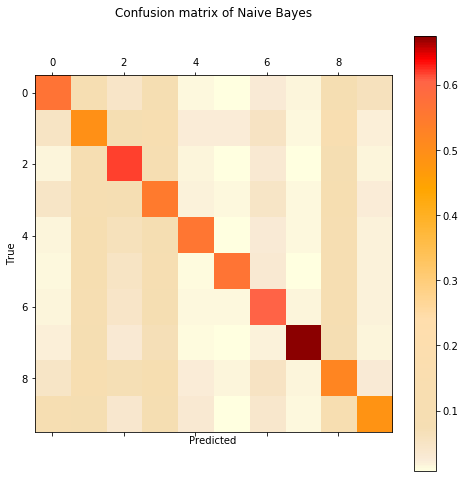

NB, WordLevel TF-IDF:  0.5262798281689408
Wall time: 10.8 s


In [115]:
%%time
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf, "Naive Bayes")
print ("NB, WordLevel TF-IDF: ", accuracy)

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

          -1       0.57      0.82      0.67    258373
           0       0.64      0.69      0.66    924247
           4       0.64      0.52      0.57    390849
           6       0.65      0.64      0.64    742495
           8       0.54      0.42      0.47     95017
           9       0.51      0.38      0.44     71550
          10       0.58      0.43      0.49    214193
          11       0.57      0.46      0.51     60434
          50       0.63      0.64      0.64    769431
         100       0.71      0.19      0.30     10839

    accuracy                           0.62   3537428
   macro avg       0.60      0.52      0.54   3537428
weighted avg       0.63      0.62      0.62   3537428

[[210930  43762  19290  34975   5759   4754  11410   4659  35706   1678]
 [ 15300 639162  62146  96274  15753  14034  36512   8759 109436   1575]
 [  4104  33463 204546  29403   5153   3710  10621   2524  27718    602]
 [ 12701  77463  41148

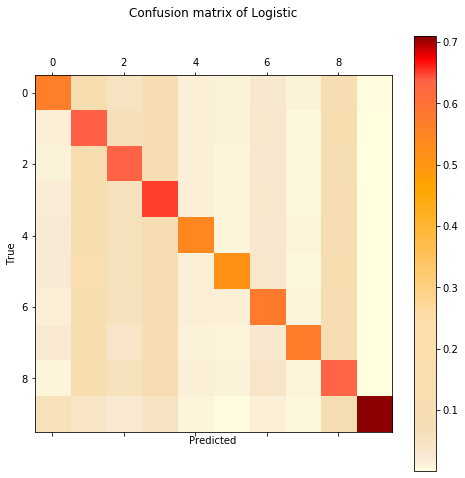

Logistic, WordLevel TF-IDF:  0.6249848760172645


In [99]:
xtest_tfidf =  tfidf_vect.transform(X_test)
from sklearn.linear_model import LogisticRegression
accuracy = train_model(LogisticRegression(random_state=0), xtrain_tfidf, y_train, xtest_tfidf, "Logistic")
print ("Logistic, WordLevel TF-IDF: ", accuracy)

In [66]:
tfidf_vect = TfidfVectorizer(analyzer='char_wb', token_pattern=r'\w{1,}', max_features=5000)
xtrain_tfidf =  tfidf_vect.fit_transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          -1       0.38      0.00      0.00    257059
           0       0.26      1.00      0.41    915278
           4       0.00      0.00      0.00    399777
           6       0.56      0.00      0.01    740972
           8       0.00      0.00      0.00     97521
           9       0.00      0.00      0.00     71828
          10       0.00      0.00      0.00    218713
          11       0.50      0.00      0.00     58284
          50       0.24      0.00      0.00    767157
         100       0.00      0.00      0.00     10839

    accuracy                           0.26   3537428
   macro avg       0.19      0.10      0.04   3537428
weighted avg       0.27      0.26      0.11   3537428

[[    38     12      6     23      2      1      8      3      7      0]
 [255884 914408 399210 737236  97405  71753 218360  58225 766162  10796]
 [     0      1      0      0      0      0      0      0      0      0]
 [   818    546    409

C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


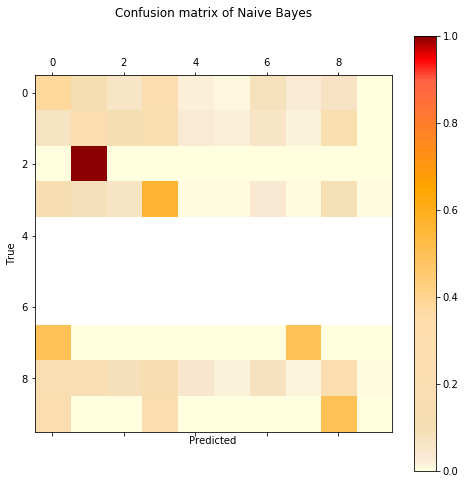

NB, WordLevel TF-IDF:  0.2595951069534136
Wall time: 10.9 s


In [67]:
%%time
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf, "Naive Bayes")
print ("NB, WordLevel TF-IDF: ", accuracy)

In [127]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

Using TensorFlow backend.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Hp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-127-8eba451d5f65>", line 1, in <module>
    from keras.models import Sequential
  File "C:\Users\Hp\Anaconda3\lib\site-packages\keras\__init__.py", line 3, in <module>
    from . import utils
  File "C:\Users\Hp\Anaconda3\lib\site-packages\keras\utils\__init__.py", line 6, in <module>
    from . import conv_utils
  File "C:\Users\Hp\Anaconda3\lib\site-packages\keras\utils\conv_utils.py", line 9, in <module>
    from .. import backend as K
  File "C:\Users\Hp\Anaconda3\lib\site-packages\keras\backend\__init__.py", line 1, in <module>
    from .load_backend import epsilon
  File "C:\Users\Hp\Anaconda3\lib\site-packages\keras\backend\load_backend.py", line 90, in <module>
    from .tensorflow_backend import *
  File "C:\Users\Hp\Anaconda3\lib\site-packages\keras\backend\tens

AttributeError: module 'tensorflow' has no attribute 'name_scope'

In [116]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


ModuleNotFoundError: No module named 'tensorflow'